# Continuous Normalizing Flow 튜토리얼: 최대 우도(maximum likelihood)를 사용한 ODE 생성 모델 학습

이것은 최대 우도(maximum likelihood)를 사용하여 훈련된 [연속 정규화 흐름(CNF)](https://arxiv.org/abs/1806.07366)을 구현합니다.

샘플 $x_1$의 우도(likelihood)를 계산하기 위해 시간에 대해 적분된 순간 변수 변환 공식을 사용합니다. 즉, 다음과 같습니다.

$$
\begin{pmatrix}
\partial x_t / \partial t \\
\partial \log p(x_t) / \partial t
\end{pmatrix} =
 \begin{pmatrix}
f(t, x_t)\\
-\text{tr}(\partial f / \partial x_t)
\end{pmatrix}
$$

이는 $d+1$ 차원 시스템으로 구현됩니다. $\partial \log p(x_t) / \partial t$를 계산하는 두 가지 일반적인 방법이 있습니다.
* 본질적으로 $f$를 $D$번 호출하여 야코비 행렬(Jacobian)의 대각합(trace)을 정확하게 계산.
* 정규 분포 또는 라데마허(Rademacher) 분포를 사용하는 Hutchinson 대각합 추정기. 다음을 사용합니다.
  $$
    \text{tr}(\partial f / \partial x_t) = \mathbb{E}_{\epsilon} \left [ \epsilon^T [\partial f / \partial x_t] \epsilon \right ]
  $$
  이것은 $f$를 한 번만 호출하여 사용할 수 있습니다. $\epsilon$은 $\mathbb{E}(\epsilon) = 0$ 및 $\text{Cov}(\epsilon) = I$가 되도록 분포되어야 합니다. 가장 자주 가우스 또는 라데마허 분포가 사용되며, 둘 다 여기에 구현되어 있습니다.

Flow Matching 방법과 비교할 때, 이것은 헤세 행렬(Hessian)의 대각합 계산과 시간에 따른 역전파(backpropagation through time)를 필요로 하므로 훈련 속도가 훨씬 느리고 수치적으로 불안정합니다.

참고: `vmap` 및 `torch.func.jacrev`가 있는 torch 버전이 필요합니다.

In [1]:
import time

import torch
from torch.distributions import MultivariateNormal
from torchdyn.core import NeuralODE

from torchcfm.models import MLP
from torchcfm.utils import sample_moons

In [2]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def exact_div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = torch.func.jacrev(u)
    return lambda x, *args: torch.trace(J(x))


def div_fn_hutch_trace(u):
    def div_fn(x, eps):
        _, vjpfunc = torch.func.vjp(u, x)
        return (vjpfunc(eps)[0] * eps).sum()

    return div_fn


class cnf_wrapper(torch.nn.Module):
    """Wraps model to a torchdyn compatible CNF format.
    Appends an additional dimension representing the change in likelihood
    over time.
    """

    def __init__(self, model, likelihood_estimator="exact"):
        super().__init__()
        self.model = model
        self.div_fn, self.eps_fn = self.get_div_and_eps(likelihood_estimator)

    def get_div_and_eps(self, likelihood_estimator):
        if likelihood_estimator == "exact":
            return exact_div_fn, None
        if likelihood_estimator == "hutch_gaussian":
            return div_fn_hutch_trace, torch.randn_like
        if likelihood_estimator == "hutch_rademacher":

            def eps_fn(x):
                return torch.randint_like(x, low=0, high=2).float() * 2 - 1.0

            return div_fn_hutch_trace, eps_fn
        raise NotImplementedError(
            f"likelihood estimator {likelihood_estimator} is not implemented"
        )

    def forward(self, t, x, *args, **kwargs):
        t = t.squeeze()
        x = x[..., :-1]

        def vecfield(y):
            return self.model(torch.cat([y, t[None]]))

        if self.eps_fn is None:
            div = torch.vmap(self.div_fn(vecfield))(x)
        else:
            div = torch.vmap(self.div_fn(vecfield))(x, self.eps_fn(x))
        dx = self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))
        return torch.cat([dx, div[:, None]], dim=-1)

In [3]:
import matplotlib.pyplot as plt
def plot_trajectories(traj):
    """Plot trajectories of some selected samples."""
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=1, alpha=0.3, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.1, alpha=0.1, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    true = sample_moons(n)
    plt.scatter(true[:,0], true[:,1], s = 4, alpha=0.5, c="orange")
    plt.legend([r"$x_0$", "Flow", r"$\hat{x}_1$", "true"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

1000: loss 3.308 time 1.44


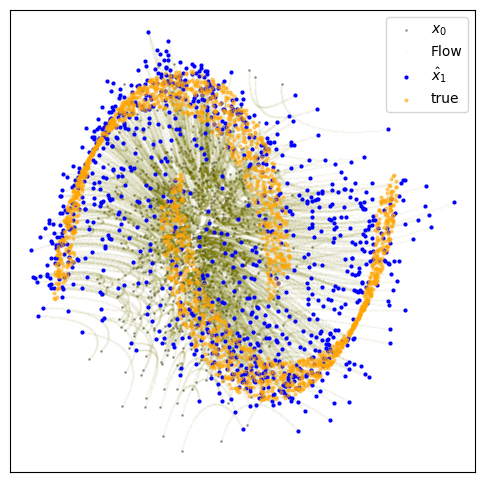

2000: loss 3.130 time 1.76


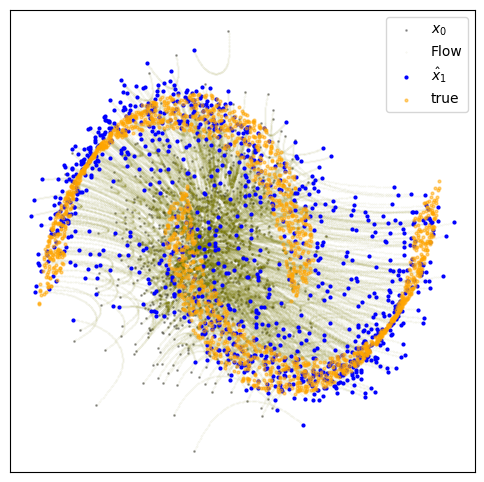

3000: loss 3.053 time 1.60


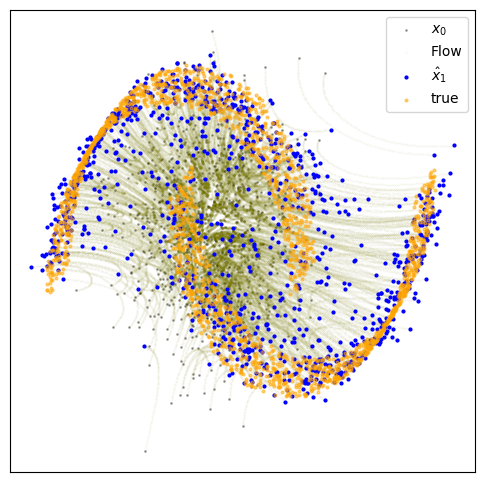

4000: loss 2.944 time 1.59


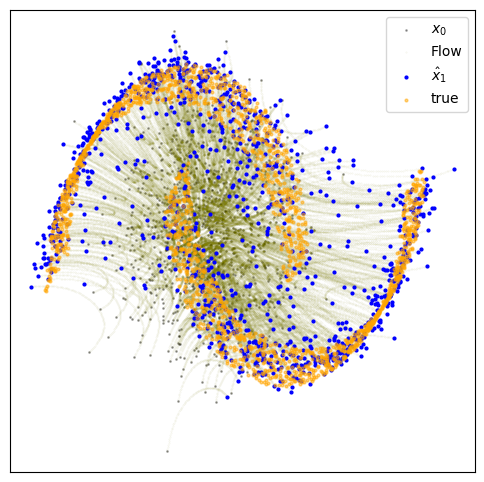

5000: loss 3.218 time 1.60


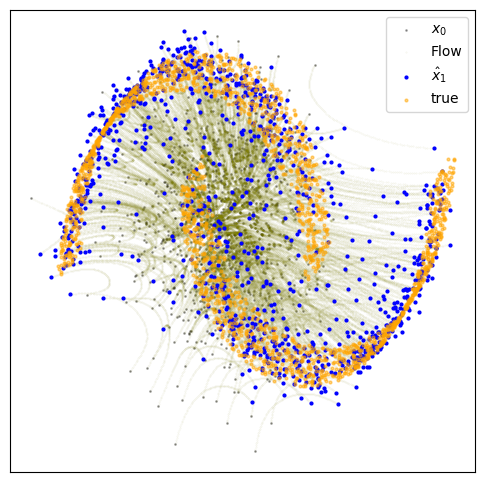

6000: loss 2.837 time 1.59


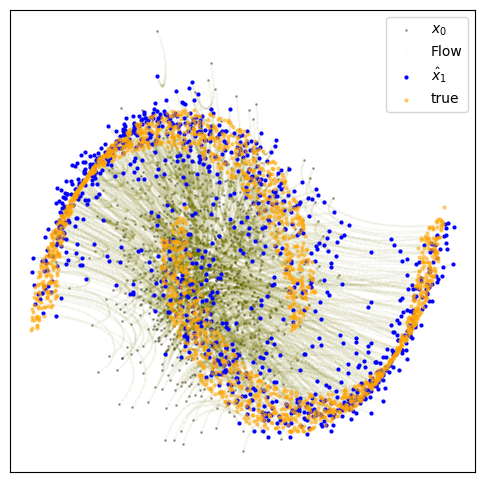

7000: loss 3.147 time 1.58


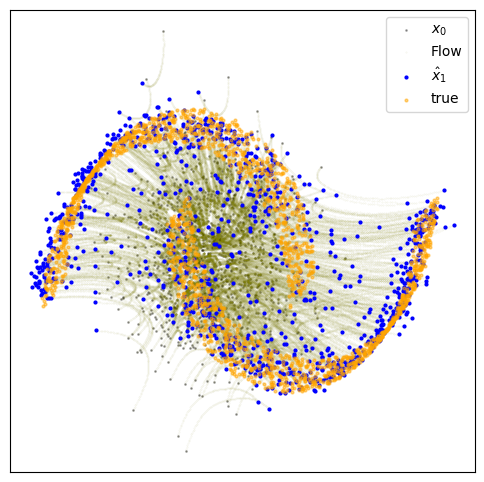

8000: loss 2.904 time 1.59


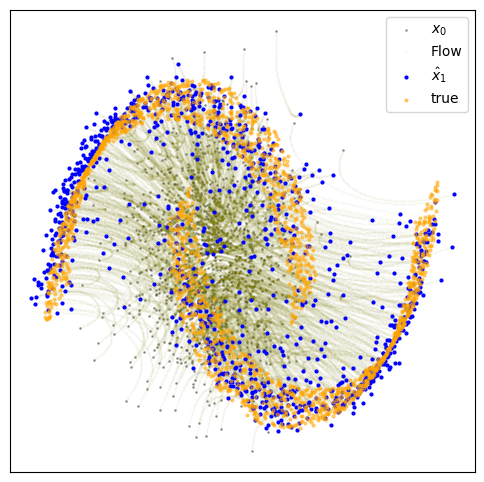

9000: loss 2.728 time 1.60


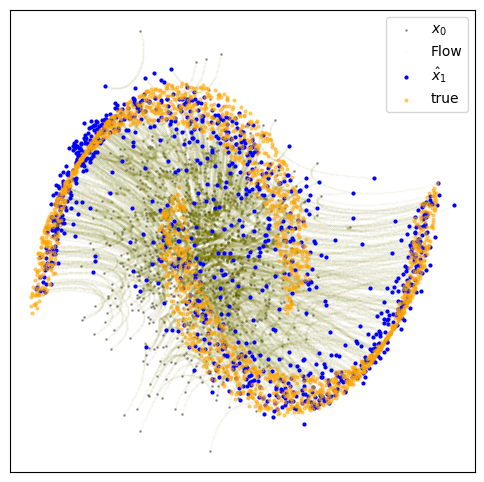

10000: loss 3.121 time 1.60


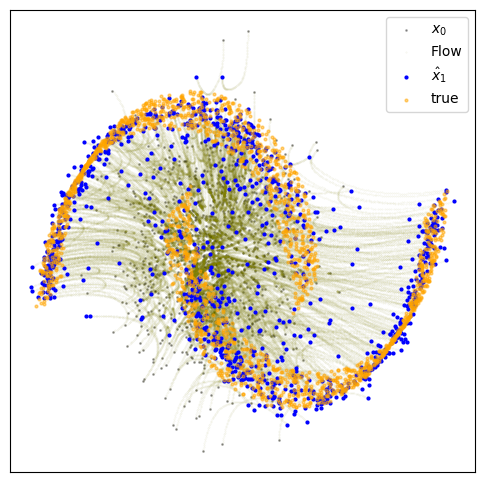

CPU times: user 15.2 s, sys: 566 ms, total: 15.7 s
Wall time: 16.7 s


In [4]:
%%time
device = "cuda" if torch.cuda.is_available() else "cpu"
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True).to(device)
prior = MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
optimizer = torch.optim.Adam(model.parameters())
steps = 100
cnf = NeuralODE(
    cnf_wrapper(model, likelihood_estimator="exact"), solver="euler", sensitivity="adjoint"
)
node = NeuralODE(torch_wrapper(model), solver="euler", sensitivity="adjoint")

start = time.time()
for k in range(10000):
    optimizer.zero_grad()
    x1 = sample_moons(batch_size).to(device)
    x0 = torch.randn(batch_size, 2, device=device)
    t = torch.rand(batch_size, device=device)
    xt = t[:, None] * x1 + (1 - t[:, None]) * x0
    ut = x1 - x0
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()

    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end

        with torch.no_grad():
            traj = node.trajectory(
                torch.randn(1024, 2, device=device),
                t_span=torch.linspace(0, 1, steps + 1, device=device),
            )
            plot_trajectories(traj.cpu().numpy())

In [9]:
def wrapped_model(f):
    def g(xt, r, t):
        return f(torch.cat([xt, r[:, None], t[:, None]], dim=-1))
    return g
def cont_wrapped_model(f):
    def g(t, xt, *args, **kwargs):
        t = t.squeeze()
        if t.dim() == 0:
            t = t * torch.ones(xt.shape[0]).to(xt)
        return f(torch.cat([xt, t[:, None], t[:, None]], dim=-1))
    return g

Your vector field does not have `nn.Parameters` to optimize.
1000: loss 5.161 time 3.60


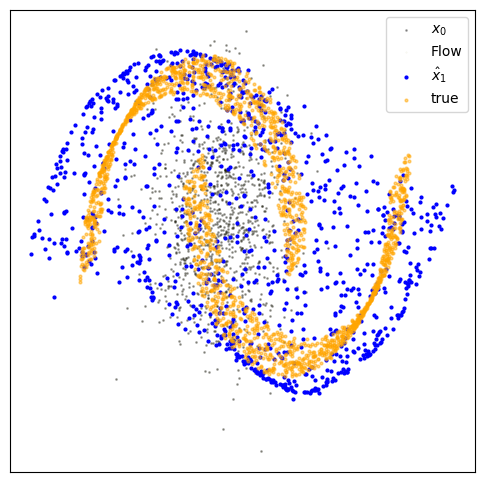

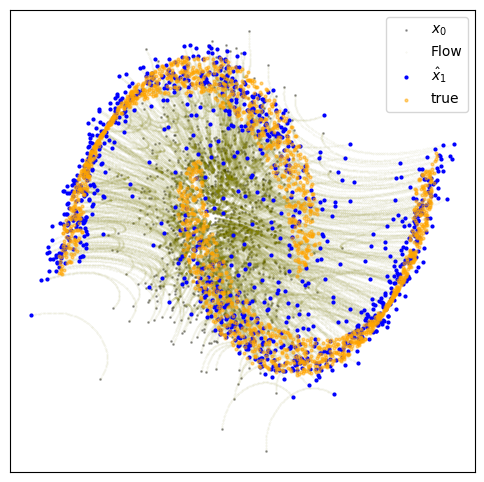

2000: loss 5.368 time 4.40


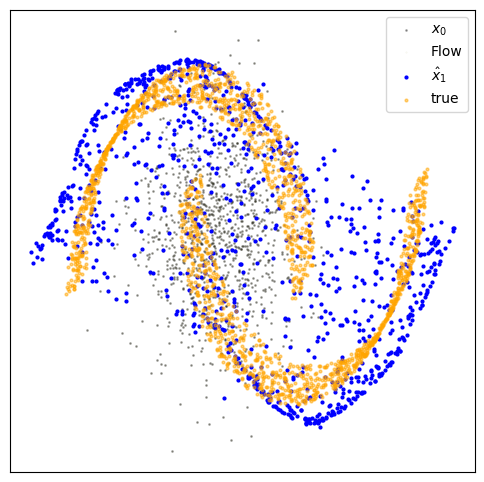

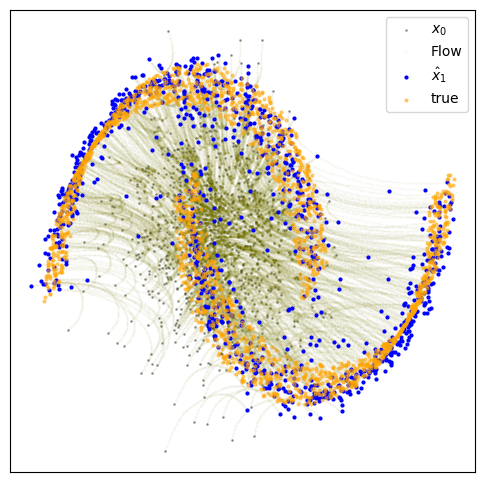

3000: loss 5.213 time 4.30


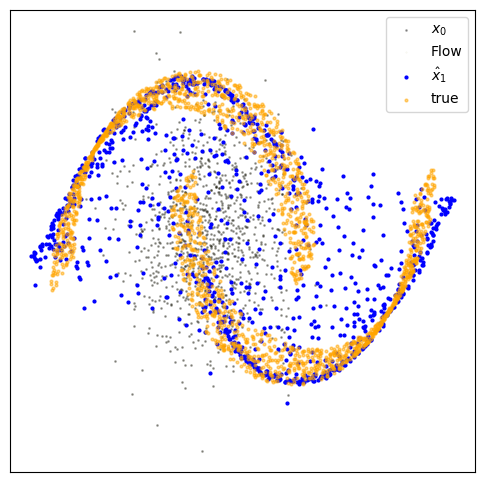

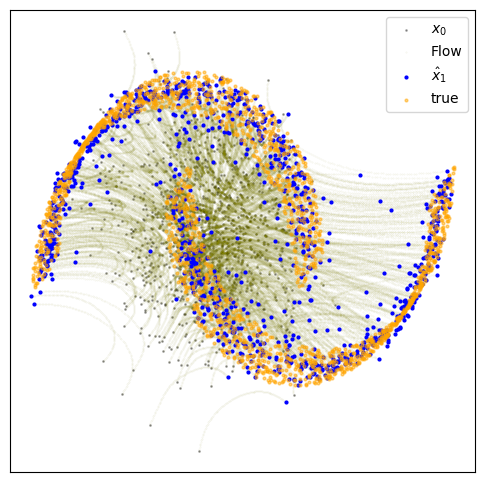

4000: loss 5.257 time 4.30


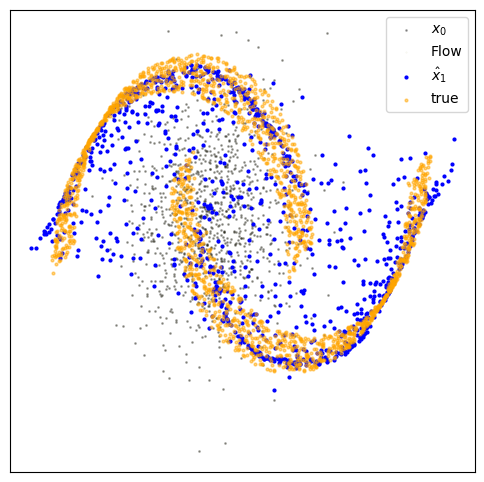

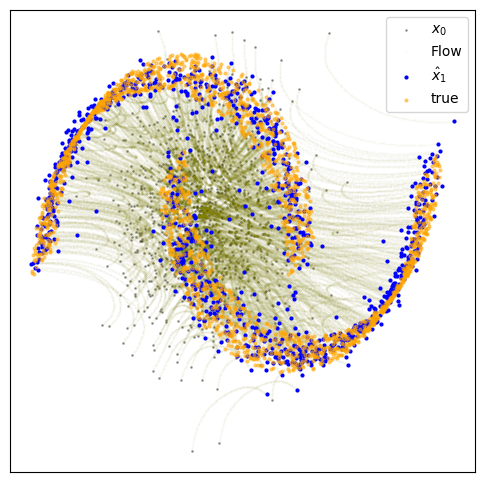

5000: loss 5.781 time 4.53


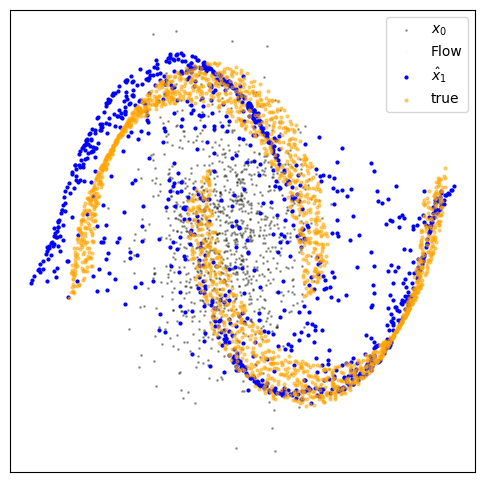

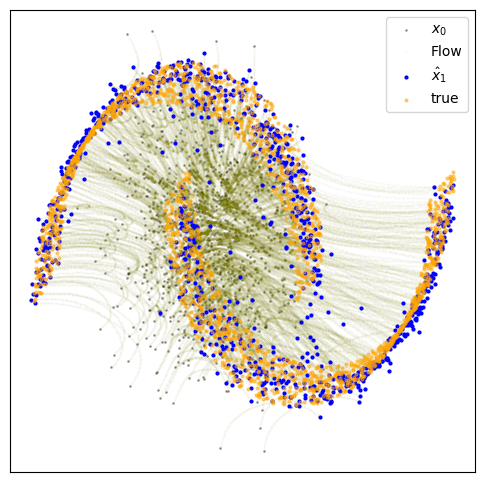

6000: loss 5.747 time 4.38


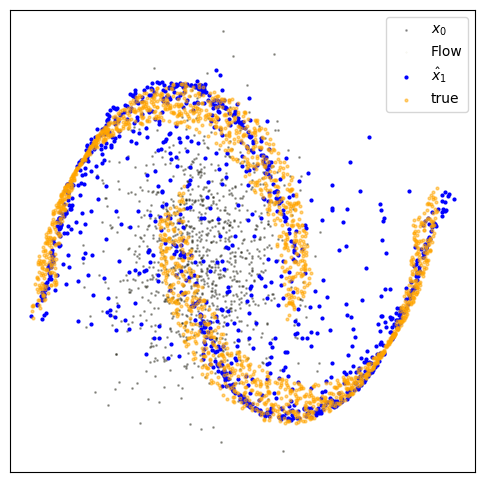

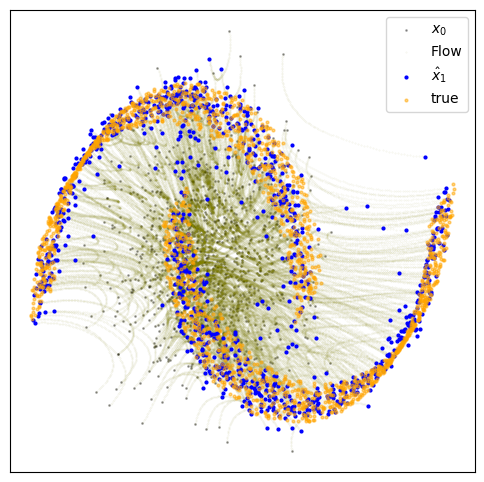

7000: loss 5.831 time 4.30


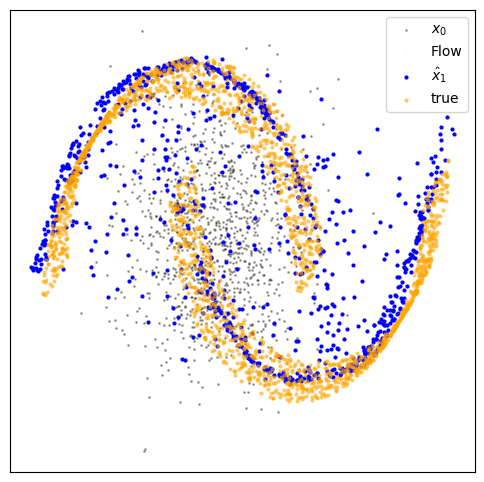

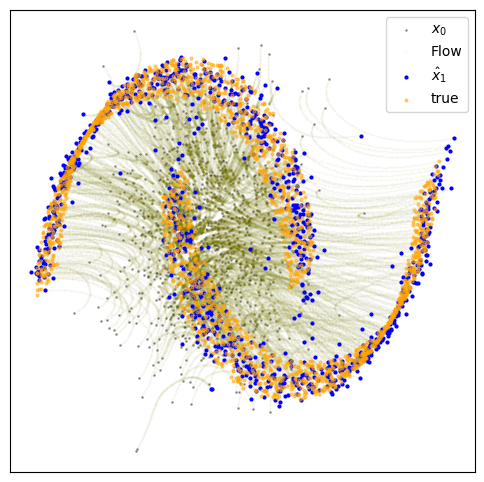

8000: loss 5.852 time 4.29


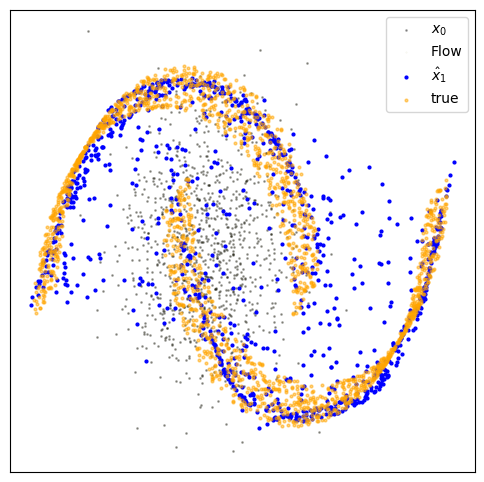

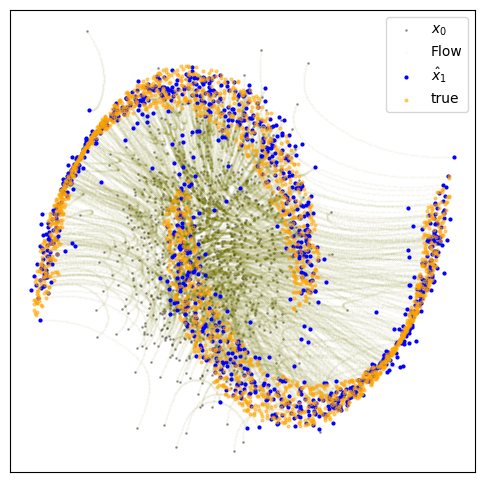

9000: loss 5.725 time 4.28


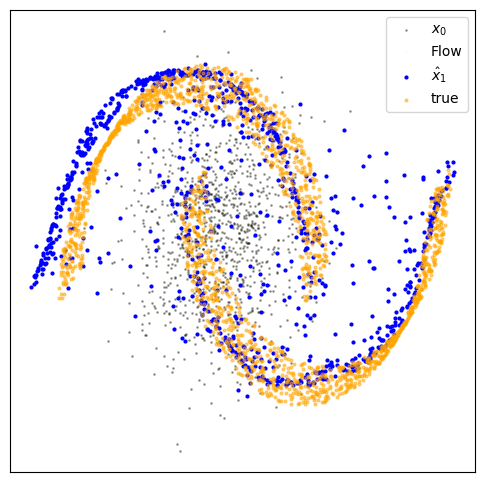

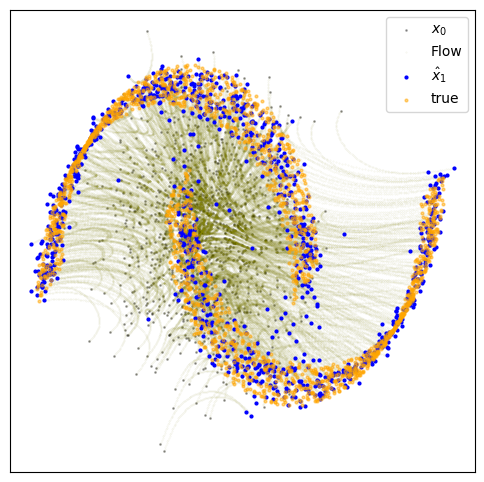

10000: loss 5.467 time 4.28


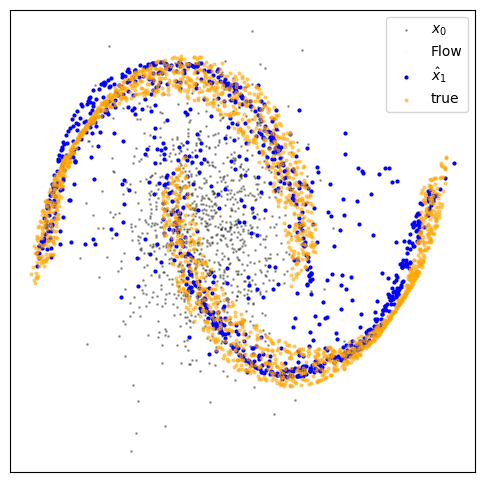

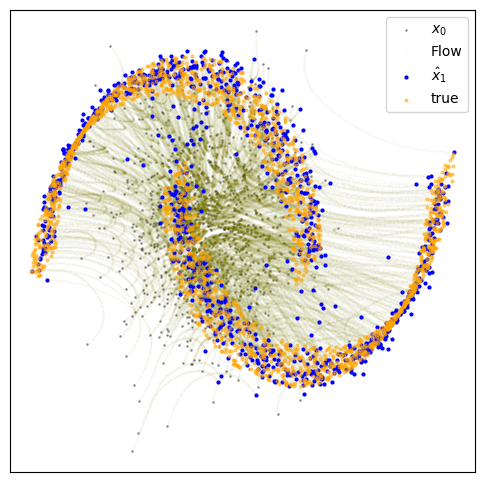

CPU times: user 41.4 s, sys: 685 ms, total: 42.1 s
Wall time: 43.5 s


In [13]:
%%time
device = "cuda" if torch.cuda.is_available() else "cpu"
dim = 2
batch_size = 10000
model = MLP(dim=dim + 2, out_dim=dim, w = 256).to(device)
wmodel = wrapped_model(model)
cmodel = cont_wrapped_model(model)
prior = MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
optimizer = torch.optim.Adam(model.parameters())
steps = 100
node = NeuralODE(cmodel, solver="dopri5", sensitivity="adjoint")
start = time.time()
def sample_rt(batch_size, neq_frac=0.25):
    t = torch.rand(batch_size, device=device)
    r = torch.rand(batch_size, device=device)
    equal_mask = torch.rand(batch_size, device=device) > neq_frac
    r[equal_mask] = t[equal_mask]
    # make t is always greater than r
    reorder_mask = (t < r).float()
    r_tmp = r * (1 - reorder_mask) + t * reorder_mask
    t_tmp = t * (1 - reorder_mask) + r * reorder_mask
    return r_tmp, t_tmp
    
for k in range(10000):
    optimizer.zero_grad()
    x = sample_moons(batch_size).to(device)
    e = torch.randn(batch_size, 2, device=device)
    r, t = sample_rt(batch_size, neq_frac=0.25)
    z = t[:, None] * e + (1 - t[:, None]) * x
    v = e - x
    u, dudt = torch.func.jvp(wmodel, (z, r, t), (v, torch.zeros_like(t), torch.ones_like(t)))
    u_tgt = v - (t - r)[:,None] * dudt
    error = u - u_tgt.detach()
    loss = torch.mean(error ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end

        with torch.no_grad():
            e = torch.randn(1024, 2, device=device)
            x = e - wmodel(e, torch.zeros(e.shape[0]).to(e), torch.ones(e.shape[0]).to(e))
            plot_trajectories(torch.stack([e, x], dim=0).cpu().numpy())
            traj = node.trajectory(
                e,
                t_span=torch.linspace(1, 0, steps + 1, device=device),
            )
            plot_trajectories(traj.cpu().numpy())